In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub
import numpy as np
import librosa
import os

import matplotlib.pyplot as plt


In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [3]:
def load_audio_from_directory(directory_path, num_files=None):
    audio_files = []
    for filename in os.listdir(directory_path)[:num_files]:
        if filename.endswith('.wav'):
            file_path = os.path.join(directory_path, filename)
            waveform, sr = librosa.load(file_path, sr=16000)
            audio_files.append(waveform)
    return audio_files

def pad_or_truncate(spectrogram, target_frames=96):
    current_frames = spectrogram.shape[0]
    if current_frames > target_frames:
        return spectrogram[:target_frames, :]
    elif current_frames < target_frames:
        pad = tf.zeros((target_frames - current_frames, spectrogram.shape[1]))
        return tf.concat([spectrogram, pad], axis=0)
    else:
        return spectrogram

def extract_all_spectrograms(file_list, target_frames=96):
    all_spectrograms = []
    for waveform in file_list:
        _, _, spectrogram = yamnet_model(waveform)
        # spectrogram = tf.squeeze(spectrogram)  <-- BUNU SİL
        spectrogram = pad_or_truncate(spectrogram, target_frames)
        all_spectrograms.append(spectrogram)
    return tf.stack(all_spectrograms)  # shape: [N, target_frames, 64]



In [4]:
how_many = 1000

sick_audio_files = load_audio_from_directory('data/data/Sick', how_many)
healthy_audio_files = load_audio_from_directory('data/data/Healthy', how_many)
none_audio_files = load_audio_from_directory('data/data/None', how_many)



In [5]:
sick_spectrogram = extract_all_spectrograms(sick_audio_files)
healthy_spectrogram = extract_all_spectrograms(healthy_audio_files)
none_spectrogram = extract_all_spectrograms(none_audio_files)

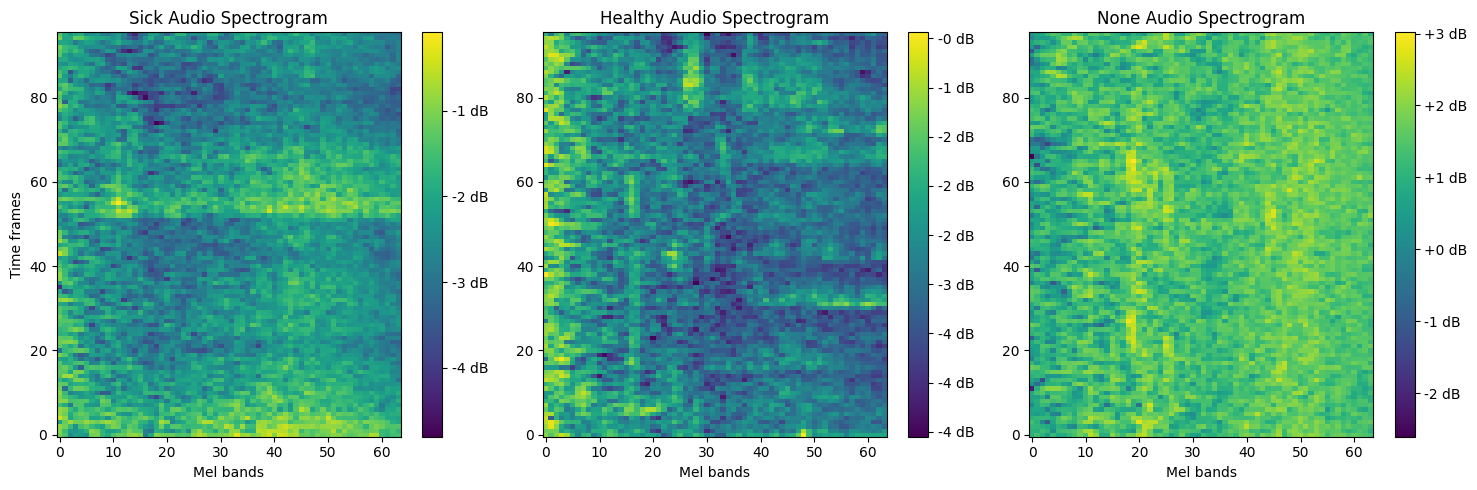

In [6]:
# Create subplots for side-by-side comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot sick spectrogram
im1 = ax1.imshow(sick_spectrogram[0], aspect='auto', origin='lower')
ax1.set_title('Sick Audio Spectrogram')
ax1.set_xlabel('Mel bands')
ax1.set_ylabel('Time frames')
plt.colorbar(im1, ax=ax1, format='%+2.0f dB')

# Extract and plot healthy spectrogram
im2 = ax2.imshow(healthy_spectrogram[0], aspect='auto', origin='lower')
ax2.set_title('Healthy Audio Spectrogram')
ax2.set_xlabel('Mel bands')
plt.colorbar(im2, ax=ax2, format='%+2.0f dB')

# Extract and plot none spectrogram
im3 = ax3.imshow(none_spectrogram[0], aspect='auto', origin='lower')
ax3.set_title('None Audio Spectrogram')
ax3.set_xlabel('Mel bands')
plt.colorbar(im3, ax=ax3, format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [7]:
X = tf.concat([sick_spectrogram, healthy_spectrogram, none_spectrogram], axis=0)
y = tf.constant([0] * len(sick_spectrogram) + [1] * len(healthy_spectrogram) + [2] * len(none_spectrogram))


# Split data


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)


# Build Model

In [9]:

model = models.Sequential([
    layers.Input(shape=(96, 64, 1)),  # spectrogram: 96 zaman, 64 frekans
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 sınıf
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,261,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,643 (4.89 MB)

 Trainable params: 1,280,643 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.fit(X_train, y_train, epochs=20, validation_split=0.1)


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4426 - loss: 1.2849 - val_accuracy: 0.5542 - val_loss: 0.9710
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5965 - loss: 0.9059 - val_accuracy: 0.6667 - val_loss: 0.8307
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6437 - loss: 0.7757 - val_accuracy: 0.6750 - val_loss: 0.8022
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6928 - loss: 0.7224 - val_accuracy: 0.6167 - val_loss: 0.8997
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6800 - loss: 0.7466 - val_accuracy: 0.6500 - val_loss: 0.8196
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7049 - loss: 0.6591 - val_accuracy: 0.6875 - val_loss: 0.7856
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7333 - loss: 0.6134 - val_accuracy: 0.7083 - val_loss: 0.7668
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7696 - loss: 0.5607 - val_accuracy: 0.6458 - v

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


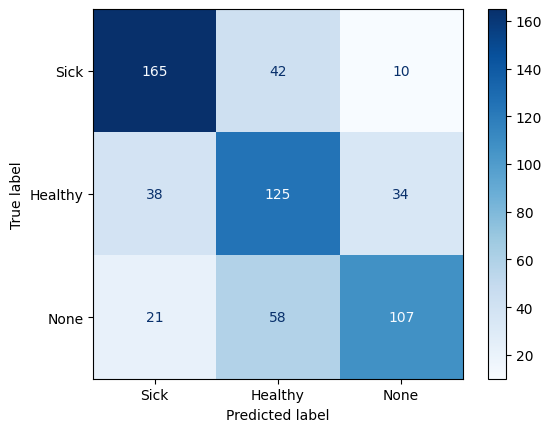

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Sick', 'Healthy', 'None'])
disp.plot(cmap='Blues')


In [14]:
class_names = ["sick", "healthy", "none"]

print(classification_report(y_test, y_pred_classes, target_names=class_names))


              precision    recall  f1-score   support

        sick       0.74      0.76      0.75       217
     healthy       0.56      0.63      0.59       197
        none       0.71      0.58      0.64       186

    accuracy                           0.66       600
   macro avg       0.67      0.66      0.66       600
weighted avg       0.67      0.66      0.66       600

